## Traditional machine learning
Feature(s): numeric column
- MeOH:H2O,
- CAN:F3BDC molar ratio,
- F3BDC (mmol),
- CAN (mmol) ,
- T (°C),
- HNO3 equivalents,
- V CAN (mL),
- V F3BDC (mL),
- Vfinal (mL),
- reaction time

target: Success
- YES or NO
- create a binary classification
   

In [1]:
import sys
import os
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from loguru import logger

logger.remove()
logger.add(sys.stderr, level="WARNING")
# Append the parent directory of your package to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..')))

Read the dataset from the zip file

In [2]:
import pandas as pd
import numpy as np
import zipfile

path_to_dataset = 'data.csv'
csv_filename = 'data.csv'

# Open the file, Correct the encoding and sep if necessary
if path_to_dataset.endswith('.zip'):
    with zipfile.ZipFile(path_to_dataset, 'r') as z:
        # Open the CSV file within the ZIP file
        with z.open(csv_filename) as f:
            # Read the CSV file into a DataFrame
            df = pd.read_csv(f, sep=',', on_bad_lines='warn')
else:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(path_to_dataset, sep=',', on_bad_lines='warn')


In [3]:
from MLPipeline import MLmodel, BinTheTarget

# Remove 'h' and 'min' and handle conversions
def convert_time(value):
    if 'h' in value:
        return float(value.replace('h', '').strip())  # Remove 'h' and convert to float
    elif 'min' in value:
        return float(value.replace('min', '').strip()) / 60  # Convert min to hours

# Function to create the new columns based on the solvent presence
def check_solvent(value, solvent):
    if f'({solvent})' in value:
        return 1
    else:
        return 0
    
def clean_value(value):
    return float(str(value).split(' ')[0])  # Take the part before any space and convert to float



# Define mapping
mapping = {'NO': 0, 'YES': 1}

# Apply mapping and convert sequences to arrays
def encode_sequence(sequence):
    return np.array([mapping[char] for char in sequence.split()])[0]

df[['MeOH', 'H2O']] = df['MeOH:H2O'].str.split('/', expand=True)
df[['CAN', 'F3BDC']] = df['CAN:F3BDC molar ratio'].str.split(':', expand=True)
df['CAN:F3BDC molar ratio'] = df['CAN'].astype(float) / df['F3BDC'].astype(float)
df['reaction time'] = df['reaction time'].apply(convert_time)
df['T (°C)'] = df['T (°C)'].replace('r.t.', 25)

# Apply the function to create the new columns
df['V CAN (mL)_H2O'] = df['V CAN (mL)'].apply(lambda x: check_solvent(str(x), 'H2O'))
df['V CAN (mL)_MeOH'] = df['V CAN (mL)'].apply(lambda x: check_solvent(str(x), 'MeOH'))
df['V CAN (mL)_MeOH:H2O'] = df['V CAN (mL)'].apply(lambda x: check_solvent(str(x), 'MeOH:H2O'))
df['V CAN (mL)'] = df['V CAN (mL)'].apply(clean_value)

df['V F3BDC (mL)_H2O'] = df['V F3BDC (mL)'].apply(lambda x: check_solvent(str(x), 'H2O'))
df['V F3BDC (mL)_MeOH'] = df['V F3BDC (mL)'].apply(lambda x: check_solvent(str(x), 'MeOH'))
df['V F3BDC (mL)_MeOH:H2O'] = df['V F3BDC (mL)'].apply(lambda x: check_solvent(str(x), 'MeOH:H2O'))
df['V F3BDC (mL)'] = df['V F3BDC (mL)'].apply(clean_value)

# Convert Yes/No to 1/0
df['Success'] = df['Success'].apply(encode_sequence)

Target = ['Success']
Features = ['MeOH',
            'H2O',
            'CAN:F3BDC molar ratio',
            'F3BDC (mmol)',
            'CAN (mmol) ',
            'T (°C)',
            'HNO3 equivalents',
            'V CAN (mL)',
            'V CAN (mL)_H2O',
            'V CAN (mL)_MeOH',
            'V CAN (mL)_MeOH:H2O',
            'V F3BDC (mL)',
            'V F3BDC (mL)_H2O',
            'V F3BDC (mL)_MeOH',
            'V F3BDC (mL)_MeOH:H2O',
            'Vfinal (mL)',
            'reaction time']

Feature_types = ['numerical']*len(Features)
input = df

/home/lsmo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def objectiveRandomForestClassifier(trial, model_instance):
    """
    Objective function for Optuna to minimize.
    """
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 6),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    # Clone the model to ensure a fresh instance each trial
    model_clone = clone(model_instance.model)
    model_clone.set_params(**params)
    
    # Define the score metric
    scoring = 'accuracy'

    # Perform cross-validation
    scores = cross_val_score(model_clone, model_instance.X_train, model_instance.y_train, cv=model_instance.cv, scoring=scoring)

    # Return the average score across all folds
    return scores.mean()


def objectiveXGBClassifier(trial, model_instance):
    """
    Objective function for Optuna to minimize for XGBClassifier.
    """
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),  # L2 regularization
    }

    # Clone the model to ensure a fresh instance each trial
    model_clone = clone(model_instance.model)
    model_clone.set_params(**params)
    
    # Define the score metric
    scoring = 'accuracy'

    # Perform cross-validation
    scores = cross_val_score(model_clone, model_instance.X_train, model_instance.y_train, cv=model_instance.cv, scoring=scoring)

    # Return the average score across all folds
    return scores.mean()


In [5]:
MODEL_NAMES = ['RandomForestClassifier', 'XGBClassifier']
TARGETS = [[i] for i in Target ]
TRAIN_SIZES = [10]

result = []
for seed in [1, 2, 3]:
    for model_name in MODEL_NAMES:
        for target in TARGETS:
            for train_size in TRAIN_SIZES:
                print(f'RUN: Model:{model_name} / Target:{target} / Train size:{train_size} / Seed:{seed}')
                
                if model_name == 'RandomForestClassifier':
                    objective = objectiveRandomForestClassifier
                elif model_name == 'XGBClassifier':
                    objective = objectiveXGBClassifier

                model = MLmodel(modelType=model_name, 
                df=input,
                randomSeed=seed,
                train_count = train_size,
                test_count = 5, 
                target=target, 
                features=Features, 
                hyperparameter_tuning=True,
                feature_types=Feature_types,
                optimization_method='optuna', 
                optimization_trials=10,
                objective=lambda trial: objective(trial, model)
                )

                model.train()
                eval, summary = model.evaluate()
                result.append({**summary, **eval, 'seed':seed})



[I 2024-09-17 12:04:01,158] A new study created in memory with name: no-name-7f1b48b5-ad3e-4df9-98ff-924d1db6a787


RUN: Model:RandomForestClassifier / Target:['Success'] / Train size:10 / Seed:1


[I 2024-09-17 12:04:01,931] Trial 0 finished with value: 0.5 and parameters: {'n_estimators': 203, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.5.
[I 2024-09-17 12:04:02,992] Trial 1 finished with value: 0.9 and parameters: {'n_estimators': 295, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.9.
[I 2024-09-17 12:04:04,377] Trial 2 finished with value: 0.5 and parameters: {'n_estimators': 275, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.9.
[I 2024-09-17 12:04:04,807] Trial 3 finished with value: 0.7 and parameters: {'n_estimators': 79, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.9.
[I 2024-09-17 12:04:05,364] Trial 4 fi

RUN: Model:XGBClassifier / Target:['Success'] / Train size:10 / Seed:1


[I 2024-09-17 12:04:10,998] Trial 0 finished with value: 0.9 and parameters: {'n_estimators': 270, 'max_depth': 3, 'learning_rate': 0.26394460294010935, 'subsample': 0.7246880551118349, 'colsample_bytree': 0.6718269439245554, 'gamma': 4.4871361743579807e-07, 'reg_alpha': 1.7379498537824121e-07, 'reg_lambda': 6.547405853927314e-07}. Best is trial 0 with value: 0.9.
[I 2024-09-17 12:04:11,269] Trial 1 finished with value: 0.7 and parameters: {'n_estimators': 137, 'max_depth': 4, 'learning_rate': 0.08006882249273808, 'subsample': 0.5567897361244121, 'colsample_bytree': 0.6097151418351594, 'gamma': 0.15996181784706964, 'reg_alpha': 0.7792375661663702, 'reg_lambda': 4.121834025329255e-05}. Best is trial 0 with value: 0.9.
[I 2024-09-17 12:04:11,498] Trial 2 finished with value: 0.9 and parameters: {'n_estimators': 94, 'max_depth': 7, 'learning_rate': 0.04130932600426636, 'subsample': 0.6503380039376061, 'colsample_bytree': 0.8962588887003582, 'gamma': 3.6983716713835906e-06, 'reg_alpha': 0.

RUN: Model:RandomForestClassifier / Target:['Success'] / Train size:10 / Seed:2


[I 2024-09-17 12:04:15,473] Trial 0 finished with value: 0.6 and parameters: {'n_estimators': 255, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.6.
/home/lsmo/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
[I 2024-09-17 12:04:16,416] Trial 1 finished with value: 0.6 and parameters: {'n_estimators': 184, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.6.
/home/lsmo/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
[I 2024-09-17 12:04:16,781] Trial 2 finished with value: 0.8 and parameters: {'n_estimators': 92, 'max_depth': 40, 'min_samp

RUN: Model:XGBClassifier / Target:['Success'] / Train size:10 / Seed:2


[I 2024-09-17 12:04:23,112] Trial 0 finished with value: 0.6 and parameters: {'n_estimators': 71, 'max_depth': 6, 'learning_rate': 0.2777654339118855, 'subsample': 0.8981021386588266, 'colsample_bytree': 0.7799863530900608, 'gamma': 0.00199117596470322, 'reg_alpha': 0.002096221491287411, 'reg_lambda': 0.008191871997327354}. Best is trial 0 with value: 0.6.
/home/lsmo/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
[I 2024-09-17 12:04:23,418] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 123, 'max_depth': 4, 'learning_rate': 0.0596989202151903, 'subsample': 0.9582158330737426, 'colsample_bytree': 0.5147067335491886, 'gamma': 0.0007561467129721819, 'reg_alpha': 3.95290778104743e-07, 'reg_lambda': 7.748814432946537e-05}. Best is trial 0 with value: 0.6.
/home/lsmo/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py

RUN: Model:RandomForestClassifier / Target:['Success'] / Train size:10 / Seed:3


[I 2024-09-17 12:04:26,941] Trial 0 finished with value: 0.7 and parameters: {'n_estimators': 85, 'max_depth': 40, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.7.
/home/lsmo/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
[I 2024-09-17 12:04:27,806] Trial 1 finished with value: 0.7 and parameters: {'n_estimators': 236, 'max_depth': None, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.7.
/home/lsmo/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
[I 2024-09-17 12:04:28,468] Trial 2 finished with value: 0.7 and parameters: {'n_estimators': 180, 'max_depth': 10, 'min

RUN: Model:XGBClassifier / Target:['Success'] / Train size:10 / Seed:3


[I 2024-09-17 12:04:35,574] Trial 0 finished with value: 0.7 and parameters: {'n_estimators': 275, 'max_depth': 7, 'learning_rate': 0.04368630626737412, 'subsample': 0.8092266436094361, 'colsample_bytree': 0.5086055756957283, 'gamma': 9.487476196769485e-05, 'reg_alpha': 0.17761748647612688, 'reg_lambda': 5.246548594825268e-07}. Best is trial 0 with value: 0.7.
/home/lsmo/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
[I 2024-09-17 12:04:36,005] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 166, 'max_depth': 13, 'learning_rate': 0.09380491126264674, 'subsample': 0.6051989495396641, 'colsample_bytree': 0.9951847608608682, 'gamma': 1.0219105290417932e-05, 'reg_alpha': 0.0016338619994705475, 'reg_lambda': 0.03535923641850007}. Best is trial 0 with value: 0.7.
/home/lsmo/.local/lib/python3.10/site-packages/sklearn/model_selection/_sp

Some information about the dataset such as the splitting, wrong smiles, total number of samples.

In [6]:
df = pd.DataFrame(result)
display(df)
df.to_csv('MOF_synthesis_traditional_ml.csv')

,modeltype,target,train_size,trues,preds,model_params,accuracy,f1_micro,f1_macro,kappa,seed
0,RandomForestClassifier,[Success],10,"[0, 0, 1, 1, 1]","[0, 0, 1, 0, 0]","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.6,0.6,0.583333,0.285714,1
1,XGBClassifier,[Success],10,"[0, 0, 1, 1, 1]","[0, 0, 1, 0, 0]","{'objective': 'binary:logistic', 'base_score':...",0.6,0.6,0.583333,0.285714,1
2,RandomForestClassifier,[Success],10,"[0, 1, 0, 0, 0]","[1, 1, 0, 1, 0]","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.6,0.6,0.583333,0.285714,2
3,XGBClassifier,[Success],10,"[0, 1, 0, 0, 0]","[1, 1, 0, 1, 0]","{'objective': 'binary:logistic', 'base_score':...",0.6,0.6,0.583333,0.285714,2
4,RandomForestClassifier,[Success],10,"[1, 0, 0, 0, 1]","[0, 0, 0, 0, 0]","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.6,0.6,0.375000,0.000000,3
5,XGBClassifier,[Success],10,"[1, 0, 0, 0, 1]","[0, 0, 0, 0, 0]","{'objective': 'binary:logistic', 'base_score':...",0.6,0.6,0.375000,0.000000,3


Text(0.5, 0.98, 'Random Forrest & XGB - MeltingPoint_molecules')

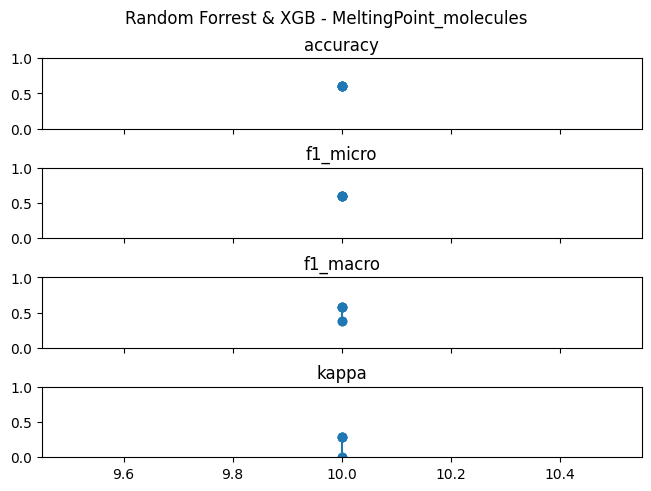

In [7]:
import matplotlib.pyplot as plt

METRICS = ['accuracy','f1_micro','f1_macro', 'kappa']
fig, ax = plt.subplots(len(METRICS), 1, sharex=True, layout = 'constrained')
ax = ax.flatten()

for i, metric in enumerate(METRICS):
    ax[i].plot(df['train_size'], df[metric], marker = 'o')
    ax[i].set_title(metric)
    ax[i].set_ylim(0,1)

fig.suptitle('Random Forrest & XGB - MOF_synthesis')